# Phase Estimation of Quantum Walks

In [1]:
#  Copyright 2023 Google LLC
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      https://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.

## Heisenberg limited phase estimation
Implements Heisenberg-Limited Phase Estimation of the Qubitized Quantum Walks as described in Section-II B. of [Encoding Electronic Spectra in Quantum Circuits with Linear T Complexity](https://arxiv.org/abs/1805.03662)

In [2]:
import cirq
import numpy as np

from qualtran._infra.gate_with_registers import get_named_qubits
from qualtran.bloqs.qubitization_walk_operator import QubitizationWalkOperator
from qualtran.bloqs.qubitization_walk_operator_test import get_walk_operator_for_1d_ising_model
from qualtran.bloqs.hubbard_model import get_walk_operator_for_hubbard_model

In [3]:
def get_resource_state(m: int):
    r"""Returns a state vector representing the resource state on m qubits from Eq.17 of Ref-1.
    
    Returns a numpy array of size 2^{m} representing the state vector corresponding to the state
    $$
        \sqrt{\frac{2}{2^m + 1}} \sum_{n=0}^{2^{m}-1} \sin{\frac{\pi(n + 1)}{2^{m}+1}}\ket{n}
    $$
    
    Args:
        m: Number of qubits to prepare the resource state on.
    
    Ref:
        1) [Encoding Electronic Spectra in Quantum Circuits with Linear T Complexity]
            (https://arxiv.org/abs/1805.03662)
            Eq. 17
    """
    den = 1 + 2 ** m
    norm = np.sqrt(2 / den)
    return norm * np.sin(np.pi * (1 + np.arange(2**m)) / den)        
    
def phase_estimation(walk: QubitizationWalkOperator, m: int) -> cirq.OP_TREE:
    """Heisenberg limited phase estimation circuit for learning eigenphase of `walk`.
    
    The method yields an OPTREE to construct Heisenberg limited phase estimation circuit 
    for learning eigenphases of the `walk` operator with `m` bits of accuracy. The 
    circuit is implemented as given in Fig.2 of Ref-1.
    
    Args:
        walk: Qubitization walk operator.
        m: Number of bits of accuracy for phase estimation. 
        
    Ref:
        1) [Encoding Electronic Spectra in Quantum Circuits with Linear T Complexity]
            (https://arxiv.org/abs/1805.03662)
            Fig. 2
    """
    reflect = walk.reflect
    walk_regs = get_named_qubits(walk.signature)
    reflect_regs = {reg.name: walk_regs[reg.name] for reg in reflect.signature}
    
    reflect_controlled = reflect.controlled(control_values=[0])
    walk_controlled = walk.controlled(control_values=[1])

    m_qubits = [cirq.q(f'm_{i}') for i in range(m)]
    state_prep = cirq.StatePreparationChannel(get_resource_state(m), name='chi_m')

    yield state_prep.on(*m_qubits)
    yield walk_controlled.on_registers(**walk_regs, control=m_qubits[0])
    for i in range(1, m):
        yield reflect_controlled.on_registers(control=m_qubits[i], **reflect_regs)
        walk = walk ** 2
        yield walk.on_registers(**walk_regs)
        yield reflect_controlled.on_registers(control=m_qubits[i], **reflect_regs)
        
    yield cirq.qft(*m_qubits, inverse=True)

In [4]:
num_sites: int = 6
eps: float = 1e-2
m_bits: int = 4

circuit = cirq.Circuit(phase_estimation(get_walk_operator_for_1d_ising_model(num_sites, eps), m=m_bits))
print(circuit)

m_0: ──────────chi_m[1]───@───────────────────────────────────────────────────────────────qft^-1───
               │          │                                                               │
m_1: ──────────chi_m[2]───┼───@(0)─────────@(0)───────────────────────────────────────────#2───────
               │          │   │            │                                              │
m_2: ──────────chi_m[3]───┼───┼────────────┼──────@(0)─────────@(0)───────────────────────#3───────
               │          │   │            │      │            │                          │
m_3: ──────────chi_m[4]───┼───┼────────────┼──────┼────────────┼──────@(0)─────────@(0)───#4───────
                          │   │            │      │            │      │            │
selection0: ──────────────W───R_L────W─────R_L────R_L────W─────R_L────R_L────W─────R_L─────────────
                          │   │      │     │      │      │     │      │      │     │
selection1: ──────────────W───R_L────W─────R_L────R_L─

## Resource estimates for 1D Ising model using generic SELECT / PREPARE 

In [5]:
from qualtran.cirq_interop.t_complexity_protocol import t_complexity

num_sites: int = 200
eps: float = 1e-5
m_bits: int = 14

walk = get_walk_operator_for_1d_ising_model(num_sites, eps)

circuit = cirq.Circuit(phase_estimation(walk, m=m_bits))
%time result = t_complexity(circuit[1:-1])
print(result)

CPU times: user 2.08 s, sys: 3.8 s, total: 5.89 s
Wall time: 1.79 s
T-count:   8.47275e+07
Rotations: 65636
Cliffords: 4.06839e+08



## Resource estimates for 2D Hubbard model using specialized SELECT / PREPARE 
Phase estimation of walk operator for 2D Hubbard Model using SELECT and PREPARE circuits from Section V of https://arxiv.org/abs/1805.03662

In [6]:
x_dim, y_dim = 20, 20
t = 20
mu = 4 * t
N = x_dim * y_dim * 2
qlambda = 2 * N * t + (N * mu) // 2
delta_E = t / 100
m_bits = int(np.ceil(np.log2(qlambda * np.pi * np.sqrt(2) / delta_E)))
walk = get_walk_operator_for_hubbard_model(x_dim, y_dim, t, mu)
circuit = cirq.Circuit(phase_estimation(walk, m=m_bits))
t_complexity.cache_clear()
%time result = t_complexity(circuit[1:-1])
print(result)

CPU times: user 14.1 s, sys: 154 ms, total: 14.3 s
Wall time: 15.2 s
T-count:   1.85053e+10
Rotations: 3.77494e+07
Cliffords: 8.31144e+10



In [7]:
from qualtran.bloqs.phase_estimation.qubitization_qpe import _qubitization_qpe_hubbard_model_large
qpe = _qubitization_qpe_hubbard_model_large.make()
t_complexity.cache_clear()
%time result = qpe.t_complexity()
print(result)

CPU times: user 13.9 s, sys: 76.6 ms, total: 14 s
Wall time: 14.9 s
T-count:   1.85053e+10
Rotations: 3.77497e+07
Cliffords: 8.31144e+10



## Flame Graphs to visualize cost for QPE on Qubitized walk operator for 2D Hubbard model

T-count:   3.54176e+06
Rotations: 164229
Cliffords: 1.0821e+07



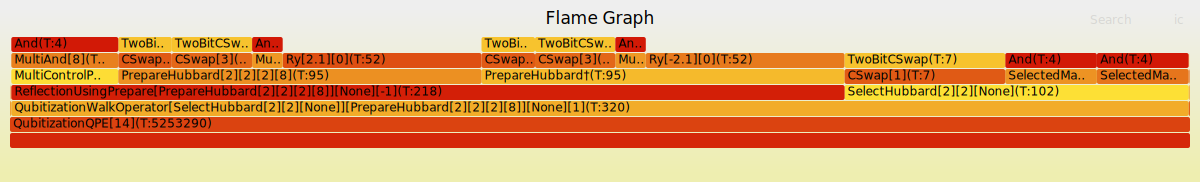

In [8]:
from qualtran.bloqs.phase_estimation.qubitization_qpe import _qubitization_qpe_hubbard_model_small
from qualtran.drawing import show_flame_graph

qpe_small = _qubitization_qpe_hubbard_model_small.make()

print(qpe_small.t_complexity())

show_flame_graph(qpe_small)